# Introduction to R - Part 3
In this final par of Introduction to R we will look at in-depth data analysis and reporting techniques. We will cover:  
1. Performing statistical analysis on data frames
2. Plotting data
3. Reporting your findings

## 1. Performing statistical analysis on data frames
R has functions for most statistical measures. We'll illustrate some of these using the NAFLD data set.

In [2]:
nafldDataset <- read.csv("nafld_dataset2.csv")

# Let's compute the mean age in the patient group and the corresponding standard deviation
mean(nafldDataset$age)
sd(nafldDataset$age)

# Now let's compute the median and IQR of age
median(nafldDataset$age)
IQR(nafldDataset$age)

[1] 53.51948

[1] 11.4944

[1] 54

[1] 13

Let's now look at the mean and 95% confidence interval of the mean of patients' heights. We know that 95% confidence intervals can be estimated as: $$\overline{x} \pm t_{0.05, n-1}\frac{s}{\sqrt{n}}$$ where $n$ is the number of observations, $t_{0.05, n-1}$ is the two-tailed 5% t-value with $n-1$ degrees of freedom, $s$ is the standard devaition and $\overline{x}$ is the mean of the observations.

In [45]:
# We need to load the stats library for this contains functions related to the t-distribution.
library(stats)

m <- mean(nafldDataset$height, na.rm=TRUE)
s <- sd(nafldDataset$height, na.rm=TRUE)
n <- sum(!is.na(nafldDataset$height))

# Calculate 95% confidence intervals of the mean height
lower <- m - qt(1 - 0.05/2, n - 1) * s / sqrt(n)
upper <- m + qt(1 - 0.05/2, n - 1) * s / sqrt(n)
print(cat(c(lower, m, upper, "\n")))

1.62336012932764 1.64513513513514 1.66691014094263 
NULL


__Q1__: Writing two extra lines all the time to calculate cofidence intervals is tedious, error-prone and boring. Write a function that takes the mean, standard deviation and number of observation and returns a vector with two elements: the lower and upper boundary of the 95% confidence interval.

Performing t-tests in R is a simple task. While you can calculate the z-statistic of the test and compare it to the critical t-value determined from a t-distribution table, R offers a function that does all of this. Let's start with a single sample t-test to see whether the mean patient height is 1.7 m.

In [49]:
t.test(nafldDataset$height, mu=1.7)


	One Sample t-test

data:  nafldDataset$height
t = -5.0216, df = 73, p-value = 3.509e-06
alternative hypothesis: true mean is not equal to 1.7
95 percent confidence interval:
 1.62336 1.66691
sample estimates:
mean of x 
 1.645135 


Next, compare the heights between patients who have fibrosis stage of 3 or higher and patients with fibrosis stage lower than 3. In this case ```t.test()``` will perform the unequal variance or Welch two-sample test.

In [47]:
t.test(nafldDataset$height[nafldDataset$bx_fib>=3], nafldDataset$height[nafldDataset$bx_fib<3])


	Welch Two Sample t-test

data:  nafldDataset$height[nafldDataset$bx_fib >= 3] and nafldDataset$height[nafldDataset$bx_fib < 3]
t = -0.4461, df = 69.053, p-value = 0.6569
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.05149005  0.03267017
sample estimates:
mean of x mean of y 
 1.639286  1.648696 


Some of the patients underwent lifestyle change and weight-reduction surgery and had their serum ALT levels measured again 6 months after the surgery. We can use the paired t-test to assess whether the treatment made any change to patients' ALT levels.

In [51]:
preSurgeryAlt <- c(45, 141, 84, 22, 84, 54, 23, 32, 78, 26, 75, 68, 38, 73, 20, 158, 49, 44)
postSurgeryAlt <- c(49, 78, 66, 34, 64, 43, 28, 29, 42, 24, 70, 41, 34, 52, 27, 87, 36, 34)
t.test(preSurgeryAlt, postSurgeryAlt, paired=TRUE)


	Paired t-test

data:  preSurgeryAlt and postSurgeryAlt
t = 2.8846, df = 17, p-value = 0.01029
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  4.118537 26.548130
sample estimates:
mean of the differences 
               15.33333 


Non-normally distributed data can be compared with non-parametric tests, such as the Wilcoxon rank sum test. For instance, when comparing AST levels between patients with fibrosis stages of more than 2 and patients with fibrosis stages of less than 3.

In [4]:
wilcox.test(nafldDataset$ast[nafldDataset$bx_fib>=3], nafldDataset$ast[nafldDataset$bx_fib<3])

Warning message in wilcox.test.default(nafldDataset$ast[nafldDataset$bx_fib >= 3], :
“cannot compute exact p-value with ties”


	Wilcoxon rank sum test with continuity correction

data:  nafldDataset$ast[nafldDataset$bx_fib >= 3] and nafldDataset$ast[nafldDataset$bx_fib < 3]
W = 815, p-value = 0.1246
alternative hypothesis: true location shift is not equal to 0


After collecting experimental data, we often want to see if there are relationships between variables. For instance, we may assume that there is a correlation between body mass index (BMI) and serum triglycerides. To find the correlation coefficient (and whether it is significantly different from 0) ```cor.test()``` can be used:

In [28]:
cor.test(nafldDataset$bmi[!is.na(nafldDataset$bmi) & !is.na(nafldDataset$tg)], 
    nafldDataset$tg[!is.na(nafldDataset$bmi) & !is.na(nafldDataset$tg)])


	Pearson's product-moment correlation

data:  nafldDataset$bmi[!is.na(nafldDataset$bmi) & !is.na(nafldDataset$tg)] and nafldDataset$tg[!is.na(nafldDataset$bmi) & !is.na(nafldDataset$tg)]
t = -0.74332, df = 71, p-value = 0.4597
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3116415  0.1451266
sample estimates:
       cor 
-0.0878747 


There is only a very weak and non-significant correlation between BMI and triglycerides.  

We are often interested in estimating the relationship between two variables (and often these realtionships are linear), therefore performing linear regression on them is quite frequent.  
As an example, we will consider the possible linear relationship between ALT and AST. We may assume that there will be a positive correlation between these two variables. Let's see if that is true:

In [30]:
regressionRes <- lm(ast~alt, data=nafldDataset)
summary(regressionRes)


Call:
lm(formula = ast ~ alt, data = nafldDataset)

Residuals:
    Min      1Q  Median      3Q     Max 
-41.016  -7.044  -1.275   4.396  80.632 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 13.00649    3.27711   3.969 0.000166 ***
alt          0.48899    0.05098   9.593 1.28e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.8 on 74 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.5543,	Adjusted R-squared:  0.5482 
F-statistic: 92.02 on 1 and 74 DF,  p-value: 1.275e-14


There is a linear relationship with significant slope and intercept, however, not all variance is explained by this realtionship (as indicated by $R^2=0.5543$).

__Q2__: Determine the mean and the 95% confidence interval on the mean of $\gamma$-glutamyl transpeptidase (GGT, an enzyme that catalyses aminoacid transport across cell membranes) in patients with fibrosis stage (bx_fib) less than 3 and in patients with fibrosis stage more than 3. Are the means different in these two patient groups?

__Q3__: Is the mean liver stiffness measurement (lsm) different between patients who had a biopsy sample size shorter than 20 mm and patients who had a biopsy sample size longer then or equal to 20 mm?

__Q4__: The fibrosis-4 score (FIB-4) has been shown to correlate well with fibrosis stage determined from liver biopsy, but has the advantage of being possible to determine from blood serum tests. It can be calculated as: FIB-4 = age × AST / (platelets x sqrt(ALT)), where AST and ALT are in units of IU/l, age is given in years and platelets in × 10<sup>9</sup>/l. Calculate the FIB-4 score for patients where all the variables are available. Is the mean FIB-4 different between patients with BMI < 25 kg/m<sup>2</sup> and patients with BMI &geq; 30 kg/m<sup>2</sup>.  
FIB-4 should correlate with fibrosis stage: determine how strong that correlation is in patients of this data set.

# 2. Plotting data
Graphical representation of experimental data is useful at least for two reasons: 1) it can serve as an exploratory analysis tool whereby it allows the initial identification of possible relationships between variables; and 2) it can help convey a message in scientific reports and papers. Textual description of experimental findings is important, but most readers look at figures and images first when they skim through a paper.  
In this section we will explore a few options to represent data in R using the ```ggplot2``` package. Part of tidyverse, ```ggplot2``` offers a smiple way to construct various plot types based on the date set we have. Its functions are highly customisable and you can find a reference for the various available options [here](https://ggplot2.tidyverse.org/reference/index.html).  
In the next sections we will have a look at three plot types: histograms, box plots and scatter plots (called point plots in ```ggplot2```).  

As you already know, histograms are used to represent the frequency distribution of variables: the range of a variable is divided into a number of bins and values in each bin are counted and represented by a bar plot. For example, we can plot the histogram of liver stiffness measurements (don't forget to load ggplo2 before plotting):

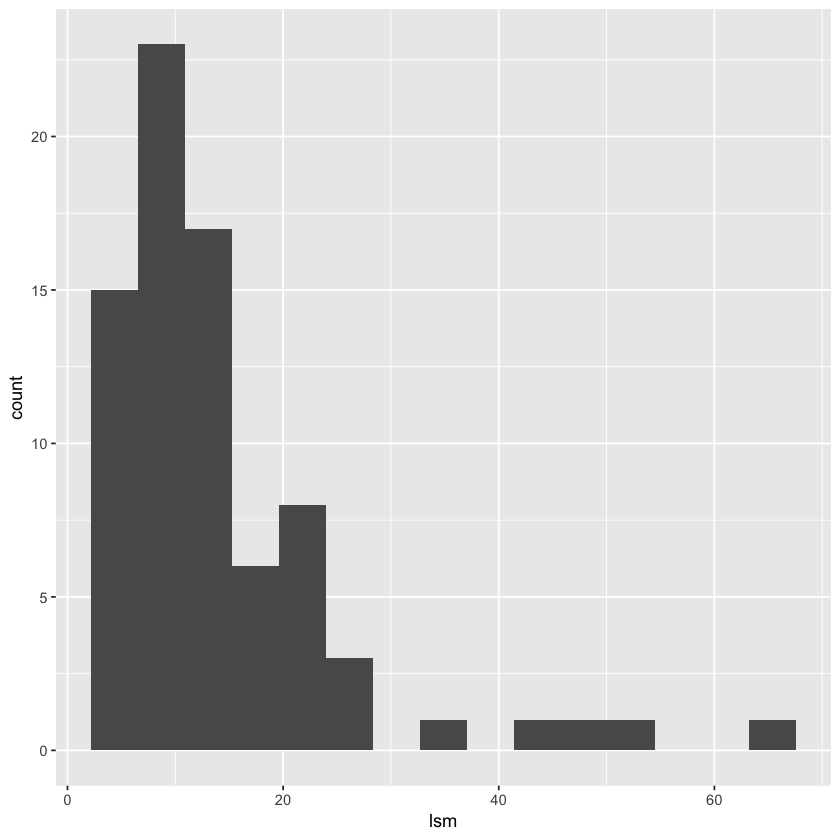

In [46]:
library(ggplot2)
ggplot(nafldDataset, aes(x=lsm)) + geom_histogram(bins=15)

Box plots are used to compare values of a variable between different subgroups. These plots will typically show the median, 25th and 75th percentiles of the variables' distribution, outliers, 25th percentile + IQR and 75th percentile + IQR. To compare BMIs in patients who had LSM measurement with an M and XL probe, we can write:

Warning message:
“Removed 3 rows containing non-finite values (stat_boxplot).”

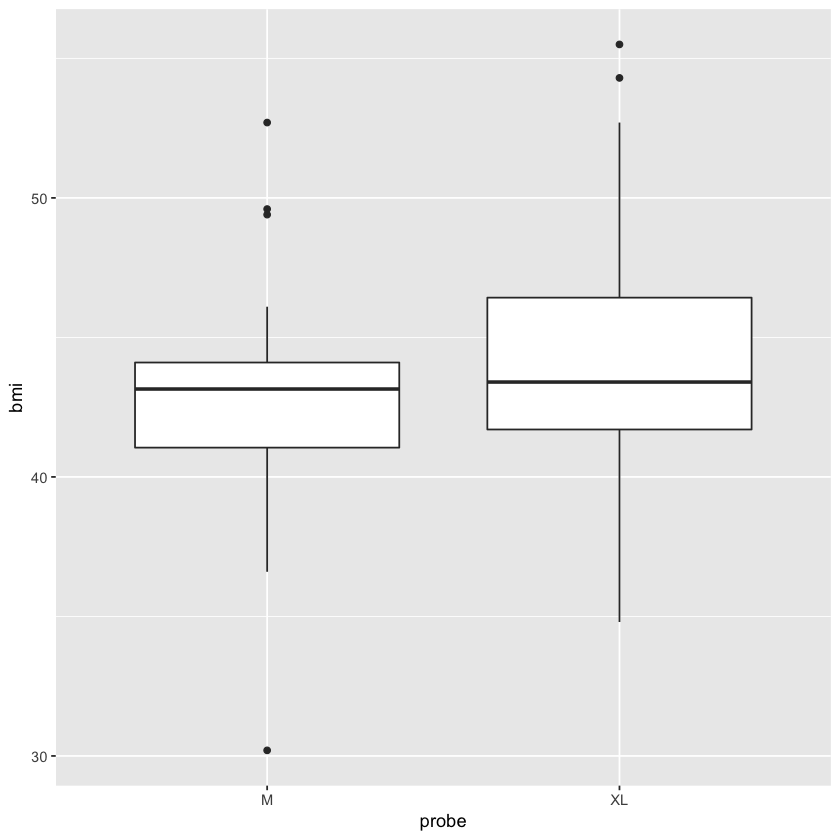

In [58]:
ggplot(nafldDataset, aes(probe, bmi)) + geom_boxplot()

By now you have seen two different plot type ```ggplot2``` can generate and have hopefully noticed some similarities and differences between the syntax of the two plots. Both started with ```ggplot(nafldDatased, aes())``` - this function call told ```ggplot2``` where the data was located and which columns of the data frame we wanted to use for the plots (specific in the ```aes``` argument). Then the plot type was added on top of the data "layer" and was specific to what we wanted to do (i.e. what geometry we were interested in). Finally, when we needed additional functionality (e.g. change the default number of bins on the histogram), the geometry was customised with an additional parameter. Most geometries support several parameters to make plots clearer or prettier.  

Finally, let's have a look at how a scatter plot looks like. We will plot AST against ALT and use ```geom_point()```:

Warning message:
“Removed 1 rows containing missing values (geom_point).”

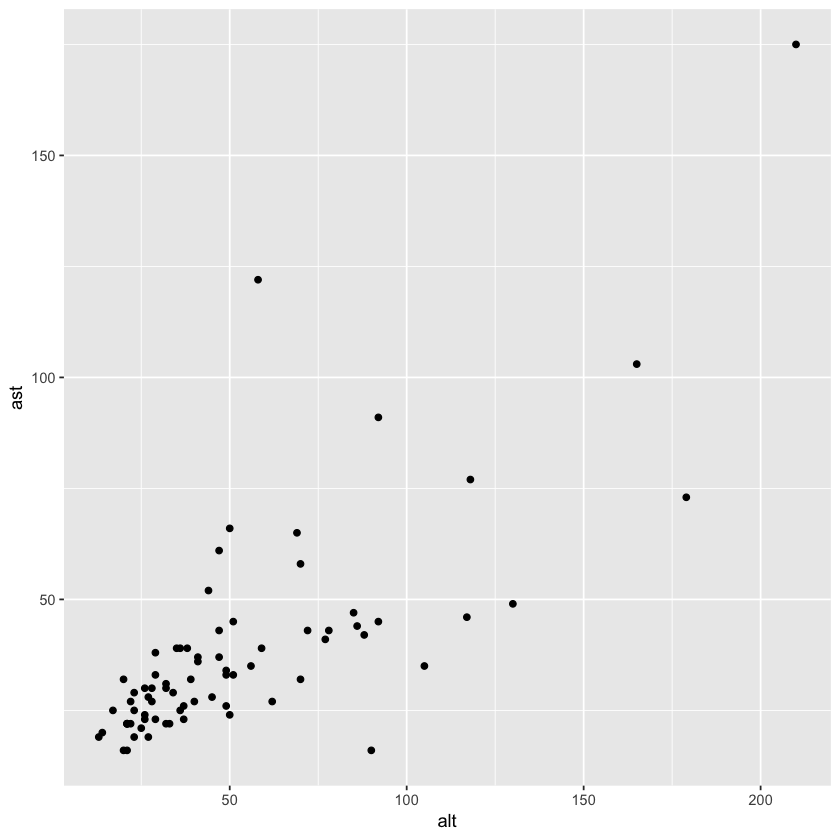

In [56]:
ggplot(nafldDataset, aes(x=alt, y=ast)) + geom_point()

Since in the previous section we determined that there is a definite linear relationship between these two measurements, let's now add the regression line on the same scatter plot. This can be done by adding another geometry "layer" on top of the point geometry. ```geom_smooth()``` takes a method argument (which in our case is a linear model) "smoothes" the data by plotting the result of the linear model to guide the eye of the reader and point out the relationship between ALT and AST.

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

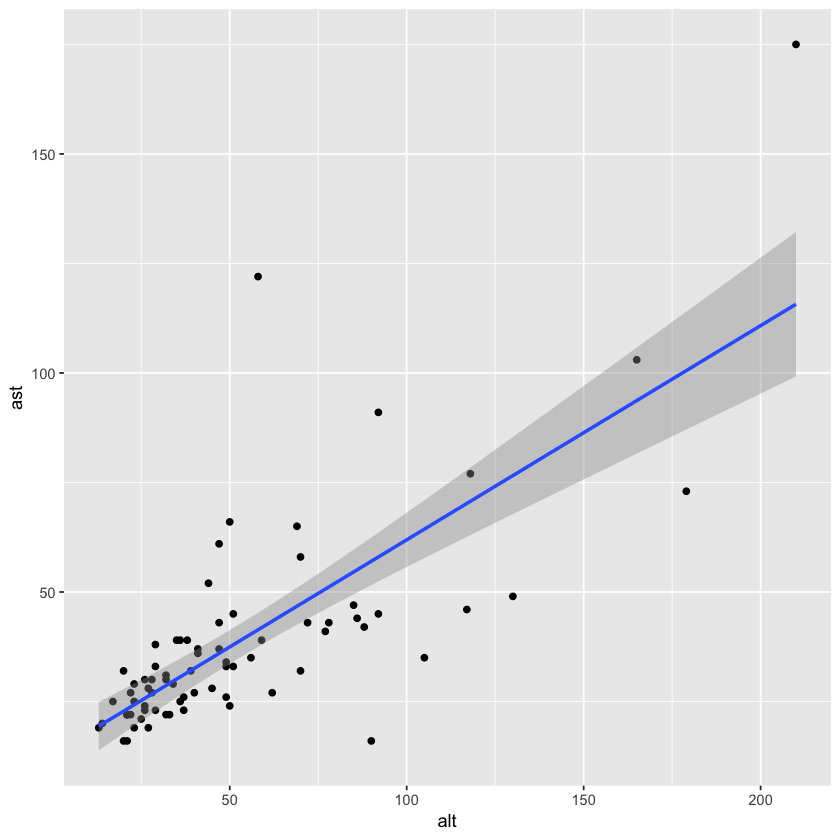

In [57]:
ggplot(nafldDataset, aes(x=alt, y=ast)) + geom_point() + geom_smooth(method=lm)

Plots created with ```ggplot2``` can further be refined (e.g. axis labels and axis limits can be changed, legend can be added). You can find a very useful and succint overview of possibilities on this [cheat sheet](https://github.com/rstudio/cheatsheets/blob/master/data-visualization-2.1.pdf).  

__Q5__: Using the FIB-4 score values determined at __Q4__, create a boxplot showing the distribution of FIB-4 scores across fibrosis stages. Label the x axis as "Fibrosis stage" and the y axis as "FIB-4 score".

# 3. Reporting your findings
Data analysis and plotting are essential parts of evaluating the results of an experiment or set of experiments. However, reporting those results is equally important and R can help with that too! Reports can be generated from R directly, using various packages - and the results can be saved in HTML, LaTeX, LaTeX beamer, DocBook XML, RTF and even Word docx formats.  
In this section we will use the __knitr__ and __markdown__ packages to generate an HTML and a docx version of a report that will contain a subset of our NAFLD patient data set, some statistical analysis, plots and text to describe our findings. We will use the markdown convention to write our report in R. Markdown is a simplified document format, which allows to encode formatting (e.g. lists, bold face, tables, links) to be defined in a text-only fashion. Markdown documents are then turned into HTML, XML, LaTeX or PDF documents in which all text appears nicely formatted.

All the code presented in this section (unless specified otherwise) will need to be saved in a file with the .Rmd extension.  

The header of our report file will define the title, author and document type we want to get in the end:  

```
---
title: "Brief report on NAFLD patients"
author: "Ferenc Mozes"
date: "17/01/2021"
output: word_document
---
```

We will start filling up the report by first inserting our data table. Since we haven't used all columns from the NAFLD data frame, we will restrict ourselves to including only the most relevant ones. Instead of manually copying data from the data frame, we will use __knitr__'s kable function to generate a markdown table and insert it into our report:

```
knitr::kable(nafldDataset[c("alt", "ast", "tg", "bmi", "lsm", "probe")], 
             format="markdown", 
             caption="NAFLD patient data. ALT, AST, BMI and triglycerides are listed in addition 
                      to liver stiffness measurements and FibroScan probe type.",
             col.names=c("ALT (IU/l)", "AST (IU/l)", "TG (mg/dl)", "BMI (kg/m2)", "LSM (kPa)","Probe type"),
             align="cccccc")
```

Then we will include the output of the correlation analysis (between BMI and triglycerides) and the results of the linear model (between AST and ALT).  

```
```{r corr}
cor.test(nafldDataset$bmi[!is.na(nafldDataset$bmi) & !is.na(nafldDataset$tg)], 
    nafldDataset$tg[!is.na(nafldDataset$bmi) & !is.na(nafldDataset$tg)])
``````

```
```{r lm}
regressionRes <- lm(ast~alt, data=nafldDataset)
summary(regressionRes)
``````

Note how code chunks are preceded by ```{r label}```. This instructs the markdown translator to evaluate the code chunk as if it were a piece of R code (which it is!). It is also noteworthy that all code chunks need to be enclosed between triple backticks (or graves).  
We will finally insert a scatter plot visualising the linear relationship between AST and ALT.

```
```{r lm_fig, fig.cap = "The relationship between AST and ALT in morbidly obese patients with NAFLD"}
ggplot(nafldDataset, aes(x=alt, y=ast)) + geom_point() + geom_smooth(method=lm)
``````

You can of course (and are encouraged to!) add explanations and interpretations of the statistical analysis you're doing, as a large part of reporting also consists of pointing out relationship and discussing findings. But for our example, the markdown code presented so far should be enough to give you an idea how reports can be generated.  
The final step is to actually export the markdown document into a formatted document:

In [74]:
library(rmarkdown)
# Export into a Word (docx) document
render("nafld_report.Rmd", output_format = "word_document")
# Export into a PDF document (via LaTeX) - may not work in the Jupyter notebook
# render("nafld_report.Rmd", output_format = "pdf_document")
# Export into a HTML web page
render("nafld_report.Rmd", output_format = "html_document")




processing file: nafld_report.Rmd


  |......                                                           |  10%
  ordinary text without R code

  |.............                                                    |  20%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................                                             |  30%
  ordinary text without R code

  |..........................                                       |  40%
label: table (with options) 
List of 1
 $ echo: logi FALSE

  |................................                                 |  50%
  ordinary text without R code

  |.......................................                          |  60%
label: corr
  |..............................................                   |  70%
  ordinary text without R code

  |....................................................             |  80%
label: lm
  |..........................................................       |  90%
  ordinary text without R code

  |.................

output file: nafld_report.knit.md



/Users/mferenc/Documents/anaconda/anaconda3/envs/Rtuts/bin/pandoc +RTS -K512m -RTS nafld_report.utf8.md --to docx --from markdown+autolink_bare_uris+ascii_identifiers+tex_math_single_backslash+smart --output nafld_report.docx --highlight-style tango 



Output created: nafld_report.docx


processing file: nafld_report.Rmd


  |......                                                           |  10%
  ordinary text without R code

  |.............                                                    |  20%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................                                             |  30%
  ordinary text without R code

  |..........................                                       |  40%
label: table (with options) 
List of 1
 $ echo: logi FALSE

  |................................                                 |  50%
  ordinary text without R code

  |.......................................                          |  60%
label: corr
  |..............................................                   |  70%
  ordinary text without R code

  |....................................................             |  80%
label: lm
  |..........................................................       |  90%
  ordinary text without R code

  |.................

output file: nafld_report.knit.md



/Users/mferenc/Documents/anaconda/anaconda3/envs/Rtuts/bin/pandoc +RTS -K512m -RTS nafld_report.utf8.md --to html4 --from markdown+autolink_bare_uris+ascii_identifiers+tex_math_single_backslash+smart --output nafld_report.html --email-obfuscation none --self-contained --standalone --section-divs --template /Users/mferenc/Documents/anaconda/anaconda3/envs/Rtuts/lib/R/library/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable 'theme:bootstrap' --include-in-header /var/folders/ky/fhnqjvsd6k90qqxy48cf8vsc0000gn/T//RtmpqPCqmT/rmarkdown-str5f551f618f1f.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: nafld_report.html
